In [33]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import time
import math
from matplotlib.patches import Rectangle
from matplotlib import cm

In [2]:
if torch.cuda.is_available():
    print("CUDA (GPU support) is available in PyTorch!")
else:
    print("CUDA (GPU support) is not available in PyTorch.")

CUDA (GPU support) is available in PyTorch!


In [3]:
torch.manual_seed(42)
np.random.seed(42)

In [51]:
class PINN(nn.Module):
    def __init__(self, layers, optimizer):
        super(PINN, self).__init__()
        self.hidden_layers = nn.ModuleList([
            nn.Linear(in_features=layers[i], out_features=layers[i+1]) 
            for i in range(len(layers)-1)
        ])
        self.optimizer = optimizer
        self.activation = nn.Tanh()
        
    def forward(self, inputs):
        for layer in self.hidden_layers[:-1]:
            inputs = self.activation(layer(inputs))
        inputs = self.hidden_layers[-1](inputs)
        return inputs
    
    def forward_pass_with_grad(self, x_t_train, x_t_train_x_zero, x_t_train_t_zero):
        x_t_train.requires_grad_(True)
        x_t_train_x_zero.requires_grad_(True)
        x_t_train_t_zero.requires_grad_(True)
        
        outputs = self.forward(x_t_train)
        u = outputs[:int(math.sqrt(x_t_train.size(0))), 0]
        s = outputs[:int(math.sqrt(x_t_train.size(0))), 1]

        outputs_t_zero = self.forward(x_t_train_t_zero)
        s_0_pred = outputs_t_zero[:int(math.sqrt(x_t_train.size(0))), 1]
        u_x_0_pred = outputs_t_zero[:int(math.sqrt(x_t_train.size(0))), 0]

        outputs_x_zero = self.forward(x_t_train_x_zero)
        u_0_t_pred = outputs_x_zero[::int(math.sqrt(x_t_train.size(0))), 0]

        u_x = torch.autograd.grad(u.sum(), x_t_train, create_graph=True, only_inputs=True)[0][:, 1]
        u_xx = torch.autograd.grad(u_x.sum(), x_t_train, create_graph=True, only_inputs=True)[0][:, 1]
        u_t = torch.autograd.grad(u.sum(), x_t_train, create_graph=True, only_inputs=True)[0][:, 0]
        s_t = torch.autograd.grad(s.sum(), x_t_train, create_graph=True, only_inputs=True)[0][:, 0]

        return u, u_x, u_xx, u_t, s_t, s_0_pred, u_0_t_pred, u_x_0_pred

    def loss_fn(self, u, u_x, u_xx, u_t, s_t, s_0_pred, u_0_t_pred, u_x_0_pred, s_0, U_0, u_0_expected):
        # Loss for heat equation in both phases
        alpha_s = 1
        loss_heat_solid = torch.mean((u_t - alpha_s * u_xx) ** 2)
        
        # Loss for Stefan condition
        L = 0.7 # Stefan number
        loss_stefan = torch.mean((L * s_t + u_x) ** 2)
        
        # Initial and boundary conditions
        loss_initial_position_of_phase_boundary = torch.mean((s_0_pred - s_0)**2)
        loss_temperature_at_fixed_boundary = torch.mean((u_0_t_pred - U_0)**2)
        loss_initial_temperature_distribution = torch.mean((u_x_0_pred.detach() - u_0_expected)**2)

        # Combine losses
        total_loss = loss_heat_solid + loss_stefan + \
                     loss_initial_position_of_phase_boundary + \
                     loss_temperature_at_fixed_boundary + \
                     loss_initial_temperature_distribution
        
        return total_loss
    
    def train_loop(self, loss_threshold, x_t_train, x_t_train_x_zero, x_t_train_t_zero, s_0, U_0, u_0_expected):
        loss_array = []
        start_time = time.time()
        loss = torch.tensor(1.0)
        epoch = 0

        while loss.item() > loss_threshold:
            self.optimizer.zero_grad()
            u, u_x, u_xx, u_t, s_t, s_0_pred, u_0_t_pred, u_x_0_pred = self.forward_pass_with_grad(
                x_t_train, x_t_train_x_zero, x_t_train_t_zero
            )
            loss = self.loss_fn(u, u_x, u_xx, u_t, s_t, s_0_pred, u_0_t_pred, u_x_0_pred, s_0, U_0, u_0_expected)
            loss.backward()
            self.optimizer.step()

            loss_array.append(loss.item())
            if epoch % 100 == 0:
                print(f'Epoch {epoch}, Loss: {loss.item()}')
            epoch += 1

        print("Training took %s seconds" % (time.time() - start_time))
        print(f"Last epoch: {epoch}, loss: {loss.item()}")

        plt.plot(loss_array)
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.grid()
        plt.title('Mean loss')
        plt.savefig("1d_poisson_equation_training_pytorch.png")
        plt.show(block=False)

In [54]:
loss_threshold = 0.7
Layers = [2, 50, 50, 50,  2]
model = PINN(Layers, None)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)
model.optimizer = optimizer
L_x, R_x = 0.0, 1.0
L_t, R_t = 0.0, 1.0
N_train_x = 10
N_train_t = 10
s_0 = 0 #2 - torch.sqrt(3)
U_0 = 1

x = np.linspace(L_x, R_x, N_train_x)
t = np.linspace(L_t, R_t, N_train_t)
X, T = np.meshgrid(x, t)
x_t_train = np.hstack((X.flatten()[:, None], T.flatten()[:, None]))
x_t_train = torch.tensor(x_t_train, dtype=torch.float32)

x_zero = np.zeros_like(x)
X_x_zero, T_x_zero = np.meshgrid(x_zero, t)
x_t_train_x_zero = np.hstack((X_x_zero.flatten()[:, None], T_x_zero.flatten()[:, None]))
x_t_train_x_zero = torch.tensor(x_t_train_x_zero, dtype=torch.float32)

t_zero = np.zeros_like(t)
X_t_zero, T_t_zero = np.meshgrid(x, t_zero)
x_t_train_t_zero = np.hstack((X_t_zero.flatten()[:, None], T_t_zero.flatten()[:, None]))
x_t_train_t_zero = torch.tensor(x_t_train_t_zero, dtype=torch.float32)

def u_0(x):
    return -x**2/2+2*x-0.5

u_0_expected = u_0(x)

Epoch 0, Loss: 1.2753463456934209
Training took 0.14141130447387695 seconds
Last epoch: 27, loss: 0.6894035669065184


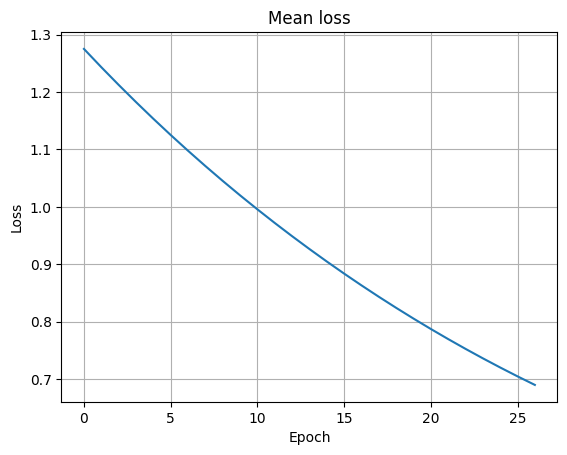

In [55]:
model.train_loop(loss_threshold, x_t_train, x_t_train_x_zero, x_t_train_t_zero, s_0, U_0, u_0_expected)

In [56]:
x_test = np.linspace(L_x, R_x, 100)
t_test = np.linspace(L_t, R_t, 100)
X_test, T_test = np.meshgrid(x_test, t_test)
x_t_test = np.hstack((X_test.flatten()[:, None], T_test.flatten()[:, None]))
x_t_test_tensor = torch.tensor(x_t_test, dtype=torch.float32)

# Evaluate the model on these points
model.eval()  # Set the model to evaluation mode
u_s_pred = model(x_t_test_tensor).detach().cpu().numpy()
u_pred = u_s_pred[:, 0]
s_pred = u_s_pred[:, 1]

# Reshape u_pred to match the grid shape
U_pred = u_pred.reshape(X_test.shape)
S_pred = s_pred.reshape(X_test.shape)
s_pred_plot = s_pred[0:len(t_test)]
print(s_pred_plot)

[0.0047291  0.00475489 0.00478357 0.00481512 0.00484951 0.00488679
 0.0049269  0.00496982 0.00501562 0.00506419 0.00511563 0.00516983
 0.00522683 0.00528662 0.00534918 0.00541451 0.00548256 0.00555336
 0.00562688 0.00570313 0.00578207 0.00586369 0.00594797 0.00603495
 0.00612456 0.00621681 0.00631168 0.00640915 0.0065092  0.00661185
 0.00671705 0.0068248  0.0069351  0.0070479  0.00716319 0.00728099
 0.00740123 0.00752394 0.0076491  0.00777663 0.00790661 0.00803894
 0.00817364 0.00831068 0.00845007 0.00859177 0.00873574 0.008882
 0.00903053 0.00918127 0.00933422 0.00948939 0.00964673 0.00980621
 0.00996782 0.01013157 0.01029742 0.0104653  0.01063527 0.01080728
 0.01098129 0.01115729 0.01133526 0.01151518 0.01169701 0.01188075
 0.01206638 0.0122539  0.01244323 0.01263437 0.01282733 0.01302203
 0.01321851 0.0134167  0.01361658 0.01381819 0.01402143 0.01422631
 0.01443279 0.01464088 0.01485055 0.01506173 0.01527443 0.01548869
 0.01570436 0.01592152 0.01614009 0.01636012 0.01658149 0.016804

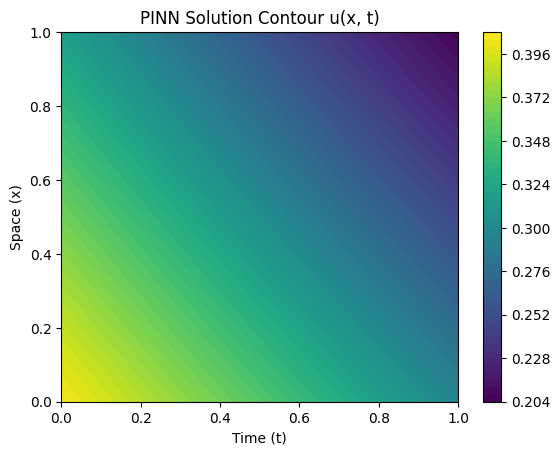

In [60]:
plt.figure()
plt.contourf(X_test, T_test, U_pred, levels=50, cmap='viridis')
plt.colorbar()
plt.xlabel('Time (t)')
plt.ylabel('Space (x)')
plt.title('PINN Solution Contour u(x, t)')
plt.show()

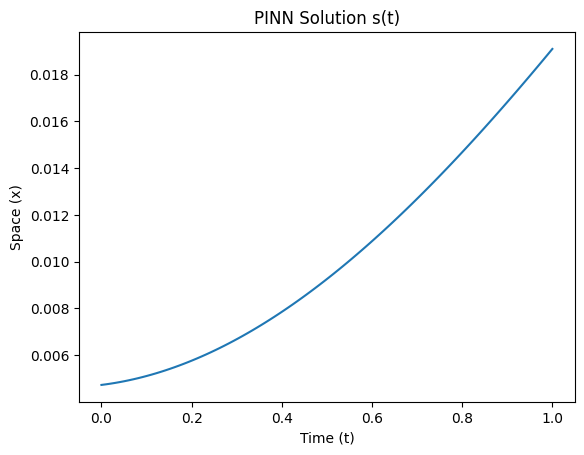

In [59]:
plt.figure()
plt.plot(t_test, s_pred_plot, label='PINN Solution s(t)')
plt.xlabel('Time (t)')
plt.ylabel('Space (x)')
plt.title('PINN Solution s(t)')
plt.show()